# CCMP Winds in a cloud-optimized-format for Pangeo

The Cross-Calibrated Multi-Platform (CCMP) Ocean Surface Wind Vector Analyses is part of the NASA Making Earth System Data Records for Use in Research Environments (MEaSUREs) Program. MEaSUREs, develops consistent global- and continental-scale Earth System Data Records by supporting projects that produce data using proven algorithms and input.  If you use this data, please give [credit](https://podaac.jpl.nasa.gov/MEaSUREs-CCMP?sections=about).  For more information, please review the [documentation](https://podaac-tools.jpl.nasa.gov/drive/files/allData/ccmp/L2.5/docs/ccmp_users_guide.pdf).

# Accessing cloud satellite data

- CCMP zarr conversion funding: Interagency Implementation and Advanced Concepts Team [IMPACT](https://earthdata.nasa.gov/esds/impact) for the Earth Science Data Systems (ESDS) program and AWS Public Dataset Program
  
### Credits: Tutorial development
* [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org) -  [Twitter](https://twitter.com/ChelleGentemann)   - Farallon Institute

### Zarr data format

 [Zarr](https://zarr.readthedocs.io/en/stable/)

### Data proximate computing
These are BIG datasets that you can analyze on the cloud without downloading the data. You can run this on your phone, a Raspberry Pi, laptop, or desktop.   
By using public cloud data, your science is reproducible and easily shared!

### To run this notebook

Code is in the cells that have <span style="color: blue;">In [  ]:</span> to the left of the cell and have a colored background

To run the code:
- option 1) click anywhere in the cell, then hold `shift` down and press `Enter`
- option 2) click on the Run button at the top of the page in the dashboard

Remember:
- to insert a new cell below press `Esc` then `b`
- to delete a cell press `Esc` then `dd`

### First start by importing libraries

In [1]:
#libs for reading data
import xarray as xr
import gcsfs
import glob
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram

#lib for dask gateway
from dask_gateway import Gateway
from dask.distributed import Client

### Start a cluster, a group of computers that will work together.

(A cluster is the key to big data analysis on on Cloud.)

- This will set up a [dask kubernetes](https://docs.dask.org/en/latest/setup/kubernetes.html) cluster for your analysis and give you a path that you can paste into the top of the Dask dashboard to visualize parts of your cluster.  
- You don't need to paste the link below into the Dask dashboard for this to work, but it will help you visualize progress.
- Try 20 workers to start (during the tutorial) but you can increase to speed things up later

In [2]:
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=1, maximum=75)
client = Client(cluster)
cluster

** ☝️ Don’t forget to click the link above or copy it to the Dask dashboard ![images.png](attachment:images.png) on the left to view the scheduler dashboard! **

### Initialize Dataset

Here we load the dataset from the zarr store. Note that this very large dataset (273 GB) initializes nearly instantly, and we can see the full list of variables and coordinates.

### Examine Metadata

For those unfamiliar with this dataset, the variable metadata is very helpful for understanding what the variables actually represent
Printing the dataset will show you the dimensions, coordinates, and data variables with clickable icons at the end that show more metadata and size.

In [3]:
zstore = 'gs://pangeo-nasa-ccmp/zarr'

fs = gcsfs.GCSFileSystem(project='pangeo-181919',requester_pays=True)

ds = xr.open_zarr(fs.get_mapper(zstore))

ds['wspd']=np.sqrt(ds.uwnd**2+ds.vwnd**2)

ds

,Array,Chunk
Bytes,174.38 GB,226.08 MB
Shape,"(48208, 628, 1440)","(2000, 157, 180)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,174.38 GB,226.08 MB
Shape,"(48208, 628, 1440)","(2000, 157, 180)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


# Plot a global image of the data on 7/28/2020

``xarray`` makes plotting the data very easy.  A nice overview of plotting with xarray is [here](http://xarray.pydata.org/en/stable/plotting.html).  Details on [.plot](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html#xarray.DataArray.plot)

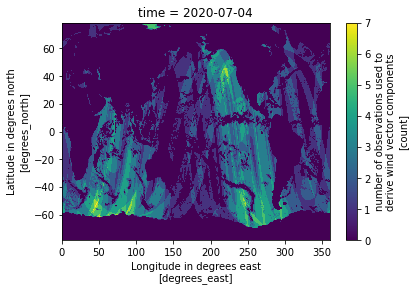

In [4]:
day = ds.sel(time='2020-07-04T00')

day.nobs.plot()

## Make a land/ocean/ice mask to show where there is actually data

### Two different ways to mask the data
1. A daily mask that removes data with sea ice and land
- sum over time for nobs (number of observations) variable
- average over a month so that land and monthly sea ice are masked out
2. A mask that removes all data that over land or where there is 'permanent' sea ice
- find when nobs is > 0
3. A climatology mask that removes all data that over land or where there has ever been sea ice
- sum over time for nobs (number of observations) variable
- average over a month so that land and monthly sea ice are masked out


# Apply the mask 
- only show data (over the ocean) where there are satellite observations

In [5]:
#daily mask removes sea ice and land
mask_obs = ds.rolling(time=180,center=True).max('time')  #4 per day 30 days = 180 rolling window
dy_mask = mask_obs.nobs>0
masked1 = ds.wspd.where(dy_mask)

In [6]:
# land mask only (includes data over sea ice)
total_nobs = ds.nobs.sum({'time'},keep_attrs=True)  #this will give you a LAND mask
land_mask = total_nobs>0
masked2 = ds.wspd.where(land_mask)

In [7]:
#climatology mask removes max sea ice extent and land
all_nobs = mask_obs.nobs.sum({'time'},keep_attrs=True)
clim_mask = all_nobs>125000
masked3 = ds.wspd.where(clim_mask)

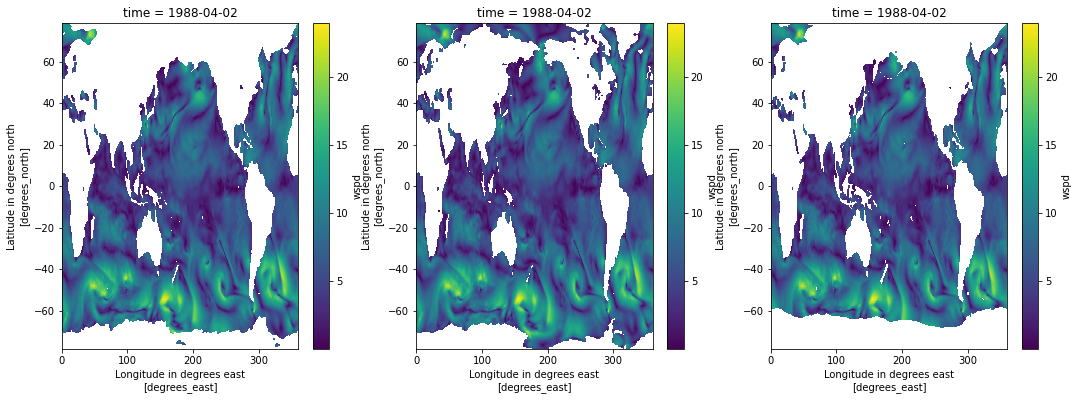

In [8]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
masked1.isel(time=1000).plot(ax=ax[0])
masked2.isel(time=1000).plot(ax=ax[1])
masked3.isel(time=1000).plot(ax=ax[2])

In [9]:
# decide which mask to use 1=land/ice, 2=land, 3=climatology
masked = masked3

In [10]:
# from http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html
def global_mean(ds):
    lat = ds.latitude
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [ ]:
m,x=[],[]
for lyr in range(1988,2020):
    subset = masked.sel(time=slice(str(lyr),str(lyr)))
    m1 = global_mean(subset)
    m1 = m1.mean().load()
    m.append(m1)
mm = xr.concat(m, dim='time')
print(np.mean(mm))

In [ ]:
bins = np.arange(0,30,.1)
h,x=[],[]
for lyr in range(1988,2020):
    subset = masked.sel(time=slice(str(lyr),str(lyr)))
    h1 = histogram(subset, bins=[bins])
    h1 = h1.load()
    print('start',lyr)
    h.append(h1)
    x.append(lyr)
    hh = xr.concat(h, dim='time')
    hh.to_netcdf('./../../data/ccmp/ccmp_annual_hist.nc')
    print('end',lyr)

In [ ]:
hhall = hh.sum('time')
hhall

In [ ]:
yr = hh[0,:].load()

In [ ]:
yr.plot()

In [ ]:
print('percentage of winds =< 2 m/s',hhall[0:21].sum()/hhall.sum())
print('percentage of winds =< 6 m/s',hhall[0:60].sum()/hhall.sum())
print('percentage of winds > 6 m/s',hhall[60:].sum()/hhall.sum())

In [ ]:
plt.rcParams['figure.figsize'] = (8,8)
for iyr in range(27):
    plt.plot(hh.wspd_bin,hh2.histogram_wspd[iyr,:]/hh2.histogram_wspd[iyr,:].sum(),label=str(x[iyr]))
plt.legend(fontsize=8)
plt.xlim(-0,32)
plt.ylim(0,.013)
plt.xlabel('CCMP Wind Speed (m s$^{-1}$)',fontsize=18)
plt.ylabel('PDF (s m$^{-1}$)',fontsize=18)
plt.text(10,0.011,'CCMPv2 1988-2020 ',fontsize=18)
plt.text(10,0.010,'Global mean = 8.3 m s$^{-1}$',fontsize=16)
plt.text(10,0.009,'67% of winds are > 6 m s$^{-1}$',fontsize=16)
plt.savefig('./../../figures/ccmp_annual_hist.png')

In [ ]:
plt.rcParams['figure.figsize'] = (8,8)
hhall = hh2.sum('time')
plt.plot(hh.wspd_bin,hhall.histogram_wspd/hhall.histogram_wspd.sum(),linewidth=5)
plt.xlim(-0,30)
plt.ylim(0,.012)
plt.xlabel('CCMP Wind Speed (m s$^{-1}$)',fontsize=18)
plt.ylabel('PDF (s m$^{-1}$)',fontsize=18)
plt.text(10,0.011,'CCMPv2 1988-2020 ',fontsize=18)
plt.text(10,0.010,'Global mean = 8.3 m s$^{-1}$',fontsize=18)
plt.text(10,0.009,'67% of winds are > 6 m s$^{-1}$',fontsize=18)
plt.savefig('./../../figures/ccmp_all_hist2.png')

In [ ]:
g6 = hhall.sel(wspd_bin=slice(6.0,35)).sum()

In [ ]:
l6 = hhall.sel(wspd_bin=slice(0,6)).sum()

In [ ]:
bins = np.arange(0,30,.1)
m,x=[],[]
for lyr in range(1988,2020):
    subset = masked.sel(time=slice(str(lyr),str(lyr)))
    m1 = subset.wspd.mean().load()
    m.append(m1)
mm = xr.concat(m, dim='time')

In [ ]:
print('global mean wind speed', mm.mean())

In [ ]:
plt.plot(xx,mm)